# Demand Forecasting for a Milk Company — Report Notebook

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
plt.style.use('seaborn-v0_8')


## Load data

In [14]:

eda = pd.read_csv('eda_summary.csv')
metrics = pd.read_csv('validation_metrics.csv')
summary = pd.read_csv('run_summary.csv')
series_scores = pd.read_csv('validation_r2_by_series.csv')
hist = pd.read_csv('viz_total_history.csv', parse_dates=['MonthStart'])
fore = pd.read_csv('viz_total_forecast.csv', parse_dates=['MonthStart'])
m_fore = pd.read_csv('forecast_monthly.csv', parse_dates=['MonthStart'])
q_fore = pd.read_csv('forecast_quarterly.csv')
y_fore = pd.read_csv('forecast_yearly.csv')
eda, metrics.head(), summary, series_scores.head()

(     date_min    date_max  n_rows  n_customers  n_items  n_routes  \
 0  2022-01-01  2024-12-31  431801          500       10        20   
 
    total_sales_qty  total_stales_qty  total_net_qty  
 0        125400651          11196757      114203894  ,
   metric     value     model
 0     r2  0.992067  lightgbm,
    r2_overall     model  train_rows  valid_rows  total_rows
 0    0.992067  lightgbm       82183       22983      105166,
   Customer Code Item Code        r2
 0       CUST001    ITEM01  0.996477
 1       CUST001    ITEM02  0.997458
 2       CUST001    ITEM03  0.997896
 3       CUST001    ITEM04  0.999650
 4       CUST001    ITEM05  0.998046)

## EDA: initial judgments, trends, seasonality

In [3]:
display(eda)
print('Date range:', eda['date_min'][0], 'to', eda['date_max'][0])
print('Rows:', int(eda['n_rows'][0]), 'Customers:', int(eda['n_customers'][0]), 'Items:', int(eda['n_items'][0]), 'Routes:', int(eda['n_routes'][0]))
print('Total Sales Qty:', int(eda['total_sales_qty'][0]), 'Total Stales Qty:', int(eda['total_stales_qty'][0]), 'Total Net Qty:', int(eda['total_net_qty'][0]))


,date_min,date_max,n_rows,n_customers,n_items,n_routes,total_sales_qty,total_stales_qty,total_net_qty
0,2022-01-01,2024-12-31,431801,500,10,20,125400651,11196757,114203894


Date range: 2022-01-01 to 2024-12-31
Rows: 431801 Customers: 500 Items: 10 Routes: 20
Total Sales Qty: 125400651 Total Stales Qty: 11196757 Total Net Qty: 114203894


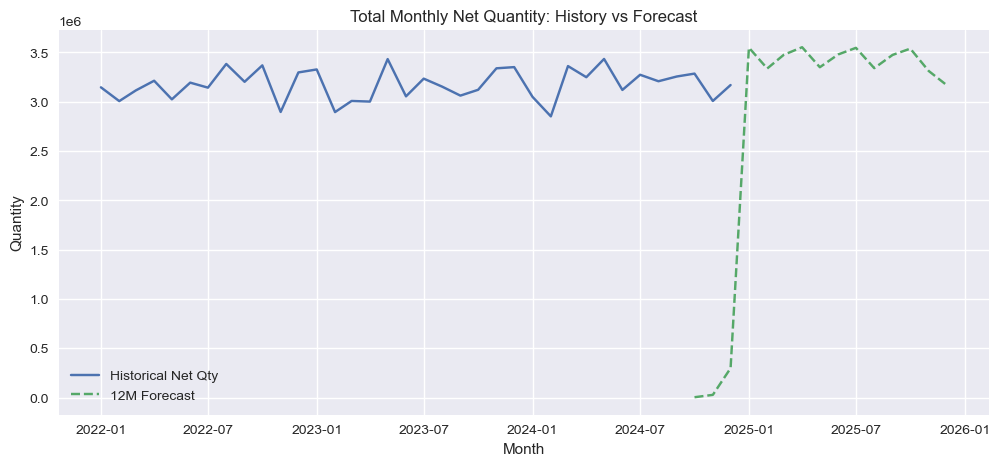

In [13]:

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(hist['MonthStart'], hist['Total_Net'], label='Historical Net Qty')
ax.plot(fore['MonthStart'], fore['Total_Forecast'], label='12M Forecast', linestyle='--')
ax.set_title('Total Monthly Net Quantity: History vs Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Quantity')
ax.legend()
plt.show()


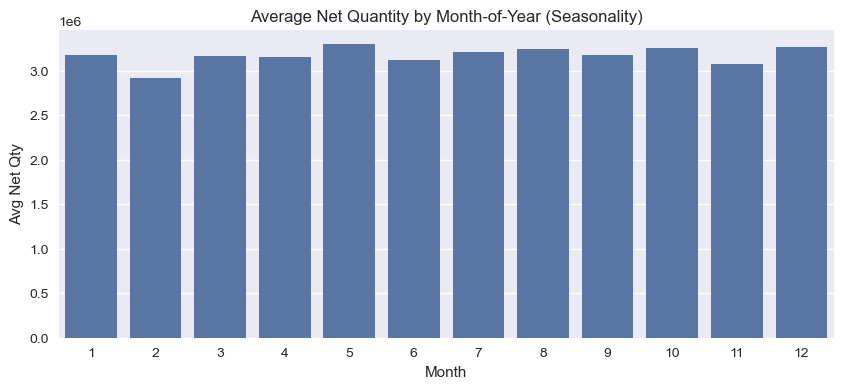

In [12]:
hist['month'] = hist['MonthStart'].dt.month
mo = hist.groupby('month', as_index=False)['Total_Net'].mean()
plt.figure(figsize=(10,4))
sns.barplot(data=mo, x='month', y='Total_Net', color='#4C72B0')
plt.title('Average Net Quantity by Month-of-Year (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Avg Net Qty')
plt.show()


## Model selection and validation

,r2_overall,model,train_rows,valid_rows,total_rows
0,0.992067,lightgbm,82183,22983,105166


,metric,value,model
0,r2,0.992067,lightgbm


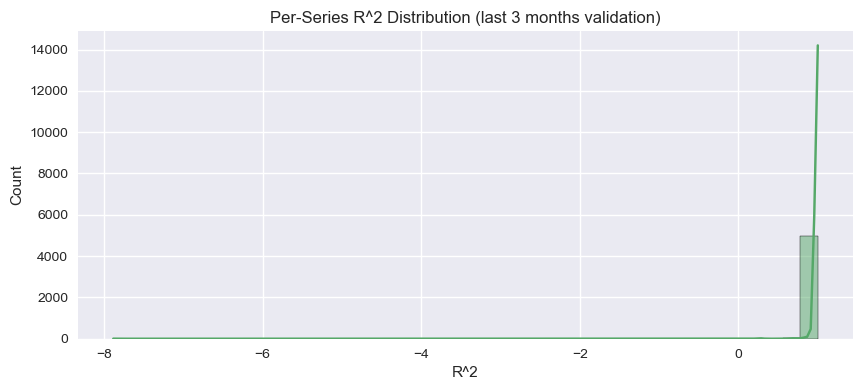

Series with R^2 < 0: 8
Series with R^2 >= 0.5: 4981
Median R^2: 0.9975469059169556


In [11]:
display(summary)
display(metrics)

plt.figure(figsize=(10,4))
sns.histplot(series_scores['r2'].dropna(), bins=40, kde=True, color='#55A868')
plt.title('Per-Series R^2 Distribution (last 3 months validation)')
plt.xlabel('R^2')
plt.show()
print('Series with R^2 < 0:', (series_scores['r2']<0).sum())
print('Series with R^2 >= 0.5:', (series_scores['r2']>=0.5).sum())
print('Median R^2:', series_scores['r2'].median())


## Forecast tables (Monthly / Quarterly / Yearly)

In [10]:

display(m_fore.head(10))
display(q_fore.head(10))
display(y_fore.head(10))

top_year = (y_fore.groupby(['Customer Code','Item Code'], as_index=False)['yhat_yearly']
                    .sum().sort_values('yhat_yearly', ascending=False).head(10))
display(top_year)


,Customer Code,Item Code,MonthStart,yhat_monthly,quarter,year
0,CUST001,ITEM01,2025-01-01,428.004398,2025Q1,2025
1,CUST001,ITEM01,2025-02-01,509.689937,2025Q1,2025
2,CUST001,ITEM01,2025-03-01,1103.280765,2025Q1,2025
3,CUST001,ITEM01,2025-04-01,411.617206,2025Q2,2025
4,CUST001,ITEM01,2025-05-01,490.914486,2025Q2,2025
5,CUST001,ITEM01,2025-06-01,1100.220479,2025Q2,2025
6,CUST001,ITEM01,2025-07-01,402.721073,2025Q3,2025
7,CUST001,ITEM01,2025-08-01,489.746873,2025Q3,2025
8,CUST001,ITEM01,2025-09-01,1106.621579,2025Q3,2025
9,CUST001,ITEM01,2025-10-01,399.393733,2025Q4,2025


,Customer Code,Item Code,quarter,yhat_quarterly
0,CUST001,ITEM01,2025Q1,2040.975100
1,CUST001,ITEM01,2025Q2,2002.752170
2,CUST001,ITEM01,2025Q3,1999.089525
3,CUST001,ITEM01,2025Q4,1993.588703
4,CUST001,ITEM02,2025Q1,1651.949655
5,CUST001,ITEM02,2025Q2,1640.029977
6,CUST001,ITEM02,2025Q3,1652.064323
7,CUST001,ITEM02,2025Q4,1645.591718
8,CUST001,ITEM03,2025Q1,2032.007507
9,CUST001,ITEM03,2025Q2,2003.335874


,Customer Code,Item Code,year,yhat_yearly
0,CUST001,ITEM01,2025,8036.405499
1,CUST001,ITEM02,2025,6589.635673
2,CUST001,ITEM03,2025,8037.894607
3,CUST001,ITEM04,2025,12151.301447
4,CUST001,ITEM05,2025,10921.845828
5,CUST001,ITEM06,2025,7011.376329
6,CUST001,ITEM07,2025,3879.051320
7,CUST001,ITEM08,2025,4529.409871
8,CUST001,ITEM09,2025,9847.187043
9,CUST001,ITEM10,2025,6970.097270


,Customer Code,Item Code,yhat_yearly
1943,CUST195,ITEM04,26852.572383
3698,CUST370,ITEM09,25934.301897
446,CUST045,ITEM07,25918.336496
4174,CUST418,ITEM05,25791.657408
546,CUST055,ITEM07,25634.481447
1776,CUST178,ITEM07,25466.702900
4375,CUST438,ITEM06,25460.057154
4648,CUST465,ITEM09,25305.445595
3891,CUST390,ITEM02,25189.268078
164,CUST017,ITEM05,25086.637482


## Insights and recommendations

In [9]:

total_sales = float(eda['total_sales_qty'][0])
total_stales = float(eda['total_stales_qty'][0])
stale_rate = total_stales / max(total_sales, 1.0)
print(f'Estimated stale rate (overall): {stale_rate:.2%}')

overall_r2 = float(summary['r2_overall'][0])
err_factor = max(0.1, 1 - overall_r2)
safety_factor = min(0.25, stale_rate + 0.5*err_factor)
print(f'Suggested safety stock factor for high-variance pairs: {safety_factor:.2%}')


Estimated stale rate (overall): 8.93%
Suggested safety stock factor for high-variance pairs: 13.93%


## Appendix: methodology

- Data preprocessing: Date parsed day-first; Net Quantity = Sales Quantity − Stales Quantity (clipped at 0).
- Aggregation: Monthly per Customer Code × Item Code.
- Features: lags 1,2,3,6,12; rolling means 3 and 6; calendar features (year, month, quarter); frequency encodings for IDs.
- Model: Gradient boosting (LightGBM preferred; XGBoost/RandomForest fallback); time-based split with last 3 months for validation; 
- Forecast: 12-month recursive monthly per series; aggregated to quarterly and yearly.
